# Numerical results

### Load packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from scipy.io import loadmat

import time
import h5py

# 1D Dam-break problem

In [2]:
# Load the .mat file
mat_data = loadmat('data/dambreakdata.mat')

h_sol = mat_data['h']
u_sol = mat_data['u']

h_sol = np.array(h_sol[0, :])
u_sol = np.array(u_sol[0, :])

# Load the numerical solution
mat_data = loadmat('data/1D-dam-break-verification.mat')

q = mat_data['q'] 
x = mat_data['x']

h_num = q[0, :]
hu_num = q[1, :]

# Initial conditions
N = 200 # Number of grid points
L = 50 # Length of the domain
x = np.linspace(0, L, N)

# Initial conditions
g = 9.81

hl = 3.5
hr = 1.25
h = np.where(x < 20, hl, hr)


In [3]:
if 0:    
    N = 1000 # Number of grid points
    L = 50 # Length of the domain
    x = np.linspace(0, L, N)

    # Initial conditions
    g = 9.81

    hl = 3.5
    hr = 1.25
    h = np.where(x < 20, hl, hr)


    # Plot initial conditions
    plt.figure(figsize=(10, 6))

    plt.plot(x, h)
    plt.xlabel('Distance x (m)')
    plt.ylabel('Water height h (m)')
    plt.title('Initial conditions for the water height h (m)')
    plt.grid()

    if 0:
        plt.savefig('plots/dam_break_initial_conditions.pdf', format='pdf')

    plt.show()


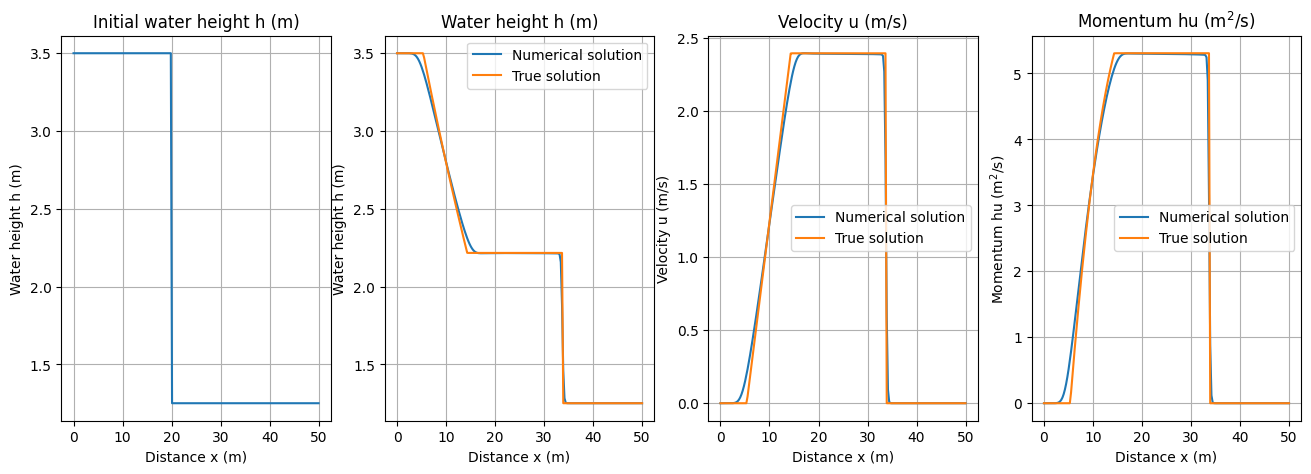

In [4]:
save = 0

# Plot the numerical solution
plt.figure(figsize=(16, 5))

plt.subplot(1, 4, 1)
plt.plot(x, h)
plt.xlabel('Distance x (m)')
plt.ylabel('Water height h (m)')
plt.grid()
plt.title('Initial water height h (m)')

plt.subplot(1, 4, 2)
plt.plot(x, h_num, label='Numerical solution')
plt.plot(x, h_sol, label='True solution')
plt.xlabel('Distance x (m)')
plt.ylabel('Water height h (m)')
plt.legend()
plt.grid()
plt.title('Water height h (m)')

plt.subplot(1, 4, 3)
plt.plot(x, hu_num/h_num, label='Numerical solution')
plt.plot(x, u_sol, label='True solution')
plt.xlabel('Distance x (m)')
plt.ylabel('Velocity u (m/s)')
plt.legend()
plt.grid()
plt.title('Velocity u (m/s)')

plt.subplot(1, 4, 4)
plt.plot(x, hu_num, label='Numerical solution')
plt.plot(x, u_sol*h_sol, label='True solution')
plt.xlabel('Distance x (m)')
plt.ylabel(r'Momentum hu (m$^2$/s)')
plt.legend()
plt.grid()
plt.title(r'Momentum hu (m$^2/$s)')

# Save figure
if save:
    plt.savefig('plots/sol_1D_val.pdf', format='pdf')

plt.show()


# Toro test cases

In [5]:
# FLUX CHOICE
# 1--> Godunov method with exact Rieamnn problem
# 2--> Lax-Friedrichs
# 3--> Lax-Wendroff
# 4--> FORCE
# 5--> HLL

save = 0

## Test 1

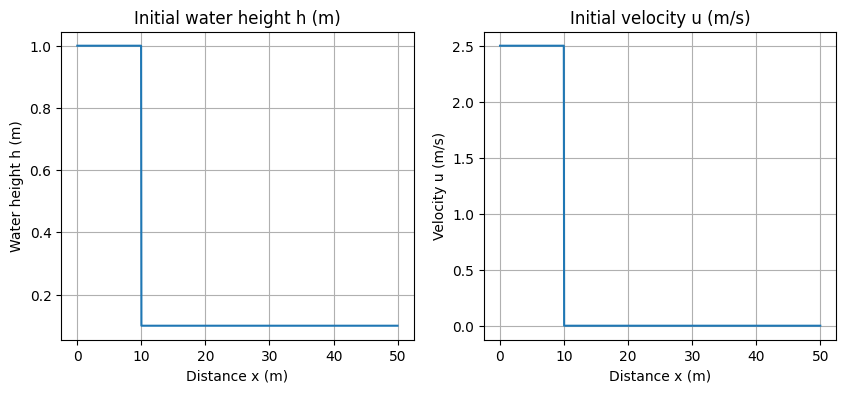

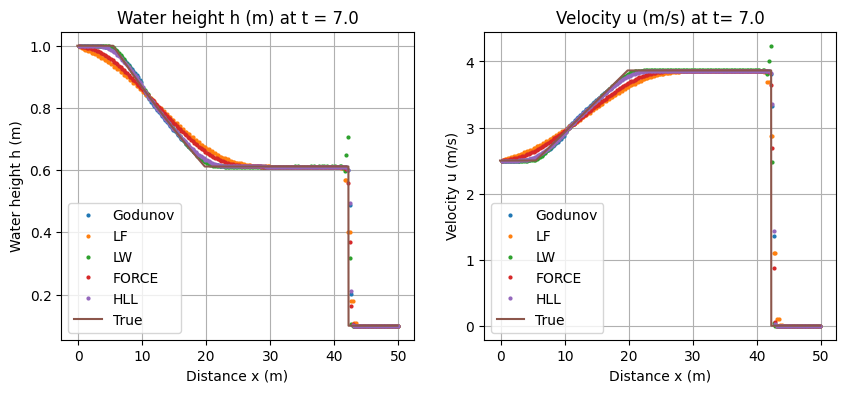

In [6]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 7.0

# Numerical parameters
Nx = 1000 # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 1.0
hR = 0.1
uL = 2.5
uR = 0.0
x0 = 10.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

# Plot the initial data
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x, h)
plt.grid()
plt.ylabel('Water height h (m)')
plt.xlabel('Distance x (m)')
plt.title('Initial water height h (m)')

plt.subplot(1, 2, 2)
plt.plot(x, u)
plt.grid()
plt.ylabel('Velocity u (m/s)')
plt.xlabel('Distance x (m)')
plt.title('Initial velocity u (m/s)')

# Save figure
if save:
    plt.savefig('plots/toro_test1_initial.pdf', format='pdf')

plt.show()

# Import numerical and true solution from Matlab
mat_data = loadmat('data/torotest1flux1.mat')
xc = mat_data['xc']
h_GOD = mat_data['h']
u_GOD = mat_data['u']
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

# Load other numerical solutions
mat_data = loadmat('data/torotest1flux2.mat')
h_LF = mat_data['h']
u_LF = mat_data['u']

mat_data = loadmat('data/torotest1flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest1flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest1flux5.mat')
h_HLL = mat_data['h']
u_HLL = mat_data['u']

mat_data = loadmat('data/torotest1flux6.mat')
h_FS = mat_data['h']
u_FS = mat_data['u']

# Plot the final data
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(xc[0,:], h_GOD[0,:], 'o', markersize = 2, label='Godunov')
plt.plot(xc[0,:], h_LF[0,:], 'o', markersize = 2, label='LF')
plt.plot(xc[0,:], h_LW[0,:], 'o', markersize = 2, label='LW')
plt.plot(xc[0,:], h_FORCE[0,:], 'o', markersize = 2, label='FORCE')
plt.plot(xc[0,:], h_HLL[0,:], 'o', markersize = 2, label='HLL')
plt.plot(xexact[0, :], hexact[0, :], label='True')
plt.legend()
plt.grid()
plt.ylabel('Water height h (m)')
plt.xlabel('Distance x (m)')
plt.title(f'Water height h (m) at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(xc[0,:], u_GOD[0,:], 'o', markersize = 2, label='Godunov')
plt.plot(xc[0,:], u_LF[0,:], 'o', markersize = 2, label='LF')
plt.plot(xc[0,:], u_LW[0,:], 'o', markersize = 2, label='LW')
plt.plot(xc[0,:], u_FORCE[0,:], 'o', markersize = 2, label='FORCE')
plt.plot(xc[0,:], u_HLL[0,:], 'o', markersize = 2, label='HLL')
plt.plot(xexact[0, :], uexact[0, :], label='True')
plt.legend()
plt.grid()
plt.ylabel('Velocity u (m/s)')
plt.xlabel('Distance x (m)')
plt.title(f'Velocity u (m/s) at t= {tend}')

# Save figure
if save:
    plt.savefig('plots/toro_test1_final.pdf', format='pdf')



## Test 2

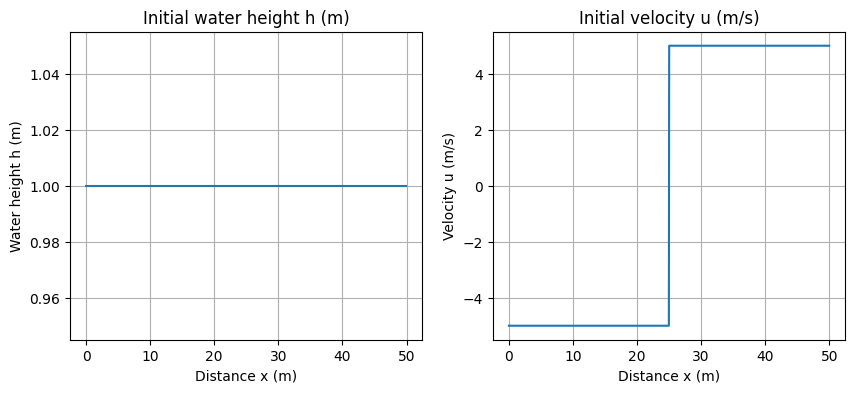

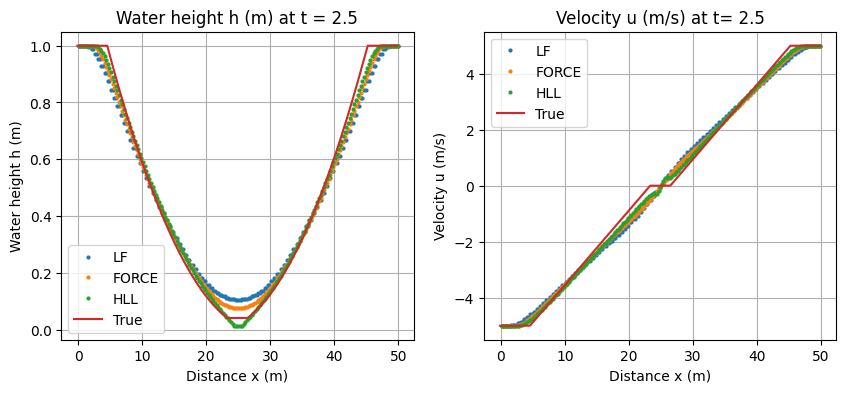

In [7]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 2.5

# Numerical parameters
Nx = 1000 # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 1.0
hR = 1.0
uL = -5.0
uR = 5.0
x0 = 25.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

# Plot the initial data
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x, h)
plt.grid()
plt.ylabel('Water height h (m)')
plt.xlabel('Distance x (m)')
plt.title('Initial water height h (m)')

plt.subplot(1, 2, 2)
plt.plot(x, u)
plt.grid()
plt.ylabel('Velocity u (m/s)')
plt.xlabel('Distance x (m)')
plt.title('Initial velocity u (m/s)')

# Save figure
if save:
    plt.savefig('plots/toro_test2_initial.pdf', format='pdf')

plt.show()

# Import numerical and true solution from Matlab 
mat_data = loadmat('data/torotest2flux2.mat')
xc = mat_data['xc']
h_LF = mat_data['h']
u_LF = mat_data['u']
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

# Load other numerical solutions
mat_data = loadmat('data/torotest2flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest2flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest2flux5.mat')
h_HLL = mat_data['h']
u_HLL = mat_data['u']

# Plot the final data
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(xc[0,:], h_LF[0,:], 'o', markersize = 2, label='LF')
#plt.plot(xc[0,:], h_LW[0,:], 'o', markersize = 2, label='LW')
plt.plot(xc[0,:], h_FORCE[0,:], 'o', markersize = 2, label='FORCE')
plt.plot(xc[0,:], h_HLL[0,:], 'o', markersize = 2, label='HLL')
plt.plot(xexact[0, :], hexact[0, :], label='True')
plt.legend()
plt.grid()
plt.ylabel('Water height h (m)')
plt.xlabel('Distance x (m)')
plt.title(f'Water height h (m) at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(xc[0,:], u_LF[0,:], 'o', markersize = 2, label='LF')
#plt.plot(xc[0,:], u_LW[0,:], 'o', markersize = 2, label='LW')
plt.plot(xc[0,:], u_FORCE[0,:], 'o', markersize = 2, label='FORCE')
plt.plot(xc[0,:], u_HLL[0,:], 'o', markersize = 2, label='HLL')
plt.plot(xexact[0, :], uexact[0, :], label='True')
plt.legend()
plt.grid()
plt.ylabel('Velocity u (m/s)')
plt.xlabel('Distance x (m)')
plt.title(f'Velocity u (m/s) at t= {tend}')

# Save figure
if save:
    plt.savefig('plots/toro_test2_final.pdf', format='pdf')

plt.show()

## Test 3

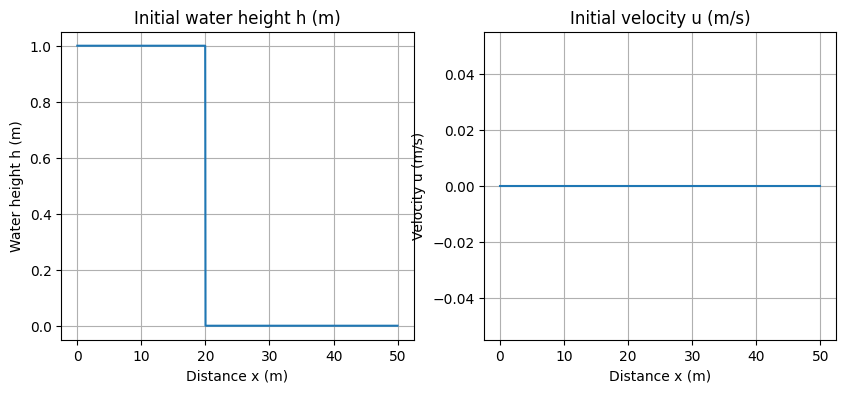

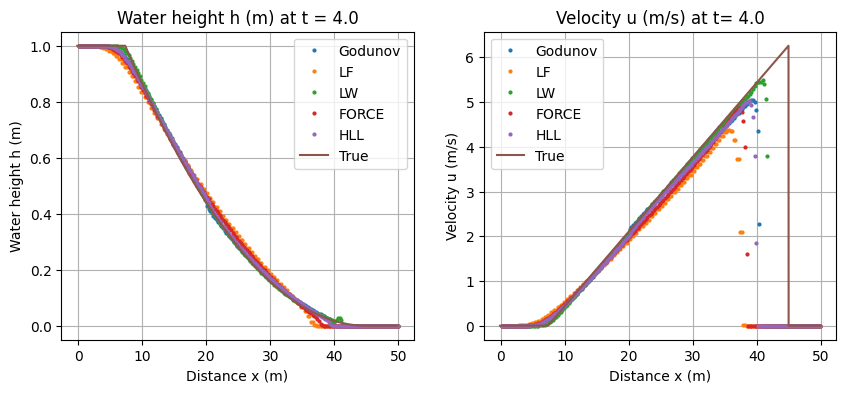

In [8]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 4.0

# Numerical parameters
Nx = 1000  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 1.0
hR = 0.0
uL = 0.0
uR = 0.0
x0 = 20.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

# Plot the initial data
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x, h)
plt.grid()
plt.ylabel('Water height h (m)')
plt.xlabel('Distance x (m)')
plt.title('Initial water height h (m)')

plt.subplot(1, 2, 2)
plt.plot(x, u)
plt.grid()
plt.ylabel('Velocity u (m/s)')
plt.xlabel('Distance x (m)')
plt.title('Initial velocity u (m/s)')

# Save figure
if save:
    plt.savefig('plots/toro_test3_initial.pdf', format='pdf')

plt.show()

# Import numerical and true solution from Matlab 
mat_data = loadmat('data/torotest6flux1.mat')  # Load another test, which have hR = 0.0 
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

mat_data = loadmat('data/torotest3flux1.mat')
xc = mat_data['xc']
h_GOD = mat_data['h']
u_GOD = mat_data['u']

mat_data = loadmat('data/torotest3flux2.mat')
h_LF = mat_data['h']
u_LF = mat_data['u']

# Load other numerical solutions
mat_data = loadmat('data/torotest3flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest3flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest3flux5.mat')
h_HLL = mat_data['h']
u_HLL = mat_data['u']

# Plot the final data
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(xc[0,:], h_GOD[0,:], 'o', markersize = 2, label='Godunov')
plt.plot(xc[0,:], h_LF[0,:], 'o', markersize = 2, label='LF')
plt.plot(xc[0,:], h_LW[0,:], 'o', markersize = 2, label='LW')
plt.plot(xc[0,:], h_FORCE[0,:], 'o', markersize = 2, label='FORCE')
plt.plot(xc[0,:], h_HLL[0,:], 'o', markersize = 2, label='HLL')
plt.plot(xexact[0, :], hexact[0, :], label='True')
plt.legend()
plt.grid()
plt.ylabel('Water height h (m)')
plt.xlabel('Distance x (m)')
plt.title(f'Water height h (m) at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(xc[0,:], u_GOD[0,:], 'o', markersize = 2, label='Godunov')
plt.plot(xc[0,:], u_LF[0,:], 'o', markersize = 2, label='LF')
plt.plot(xc[0,:], u_LW[0,:], 'o', markersize = 2, label='LW')
plt.plot(xc[0,:], u_FORCE[0,:], 'o', markersize = 2, label='FORCE')
plt.plot(xc[0,:], u_HLL[0,:], 'o', markersize = 2, label='HLL')
plt.plot(xexact[0, :], uexact[0, :], label='True')
plt.legend()
plt.grid()
plt.ylabel('Velocity u (m/s)')
plt.xlabel('Distance x (m)')
plt.title(f'Velocity u (m/s) at t= {tend}')

# Save figure
if save:
    plt.savefig('plots/toro_test3_final.pdf', format='pdf')

plt.show()

## Test 4

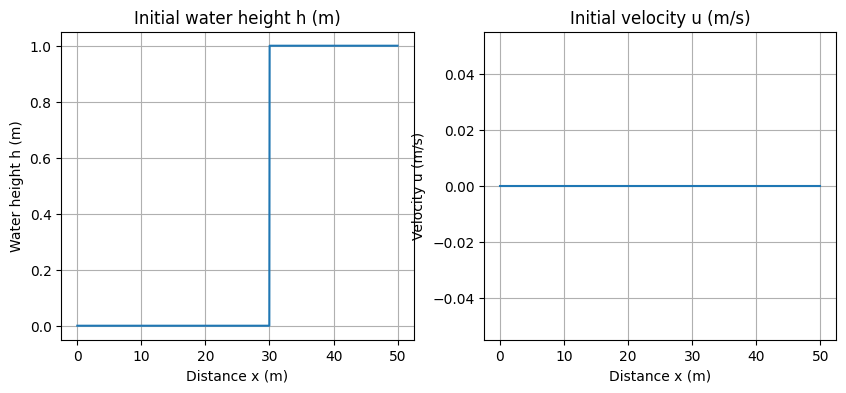

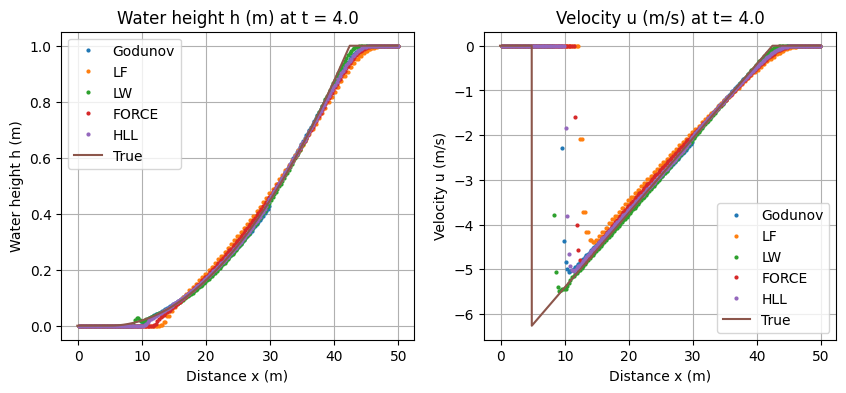

In [9]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 4.0

# Numerical parameters
Nx = 1000  # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 0.0
hR = 1.0
uL = 0.0
uR = 0.0
x0 = 30.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

# Plot the initial data
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x, h)
plt.grid()
plt.ylabel('Water height h (m)')
plt.xlabel('Distance x (m)')
plt.title('Initial water height h (m)')

plt.subplot(1, 2, 2)
plt.plot(x, u)
plt.grid()
plt.ylabel('Velocity u (m/s)')
plt.xlabel('Distance x (m)')
plt.title('Initial velocity u (m/s)')

# Save figure
if save:
    plt.savefig('plots/toro_test4_initial.pdf', format='pdf')

plt.show()

# Import numerical and true solution from Matlab - Godunov method and split upwind does not work
mat_data = loadmat('data/torotest7flux1.mat')  # Load another test, which have hR = 0.0 
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

# Load other numerical solutions
mat_data = loadmat('data/torotest4flux1.mat')
xc = mat_data['xc']
h_GOD = mat_data['h']
u_GOD = mat_data['u']

mat_data = loadmat('data/torotest4flux2.mat')
h_LF = mat_data['h']
u_LF = mat_data['u']

mat_data = loadmat('data/torotest4flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest4flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest4flux5.mat')
h_HLL = mat_data['h']
u_HLL = mat_data['u']

# Plot the final data
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(xc[0,:], h_GOD[0,:], 'o', markersize = 2, label='Godunov')
plt.plot(xc[0,:], h_LF[0,:], 'o', markersize = 2, label='LF')
plt.plot(xc[0,:], h_LW[0,:], 'o', markersize = 2, label='LW')
plt.plot(xc[0,:], h_FORCE[0,:], 'o', markersize = 2, label='FORCE')
plt.plot(xc[0,:], h_HLL[0,:], 'o', markersize = 2, label='HLL')
plt.plot(xexact[0, :], hexact[0, :], label='True')
plt.legend()
plt.grid()
plt.ylabel('Water height h (m)')
plt.xlabel('Distance x (m)')
plt.title(f'Water height h (m) at t = {tend}')

plt.subplot(1, 2, 2)

plt.plot(xc[0,:], u_GOD[0,:], 'o', markersize = 2, label='Godunov')
plt.plot(xc[0,:], u_LF[0,:], 'o', markersize = 2, label='LF')
plt.plot(xc[0,:], u_LW[0,:], 'o', markersize = 2, label='LW')
plt.plot(xc[0,:], u_FORCE[0,:], 'o', markersize = 2, label='FORCE')
plt.plot(xc[0,:], u_HLL[0,:], 'o', markersize = 2, label='HLL')
plt.plot(xexact[0, :], uexact[0, :], label='True')
plt.legend()
plt.grid()
plt.ylabel('Velocity u (m/s)')
plt.xlabel('Distance x (m)')
plt.title(f'Velocity u (m/s) at t= {tend}')

# Save figure
if save:
    plt.savefig('plots/toro_test4_final.pdf', format='pdf')

plt.show()

## Test 5

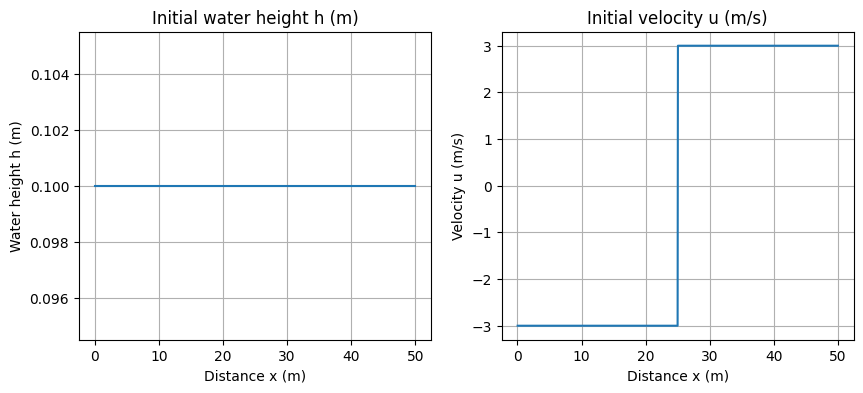

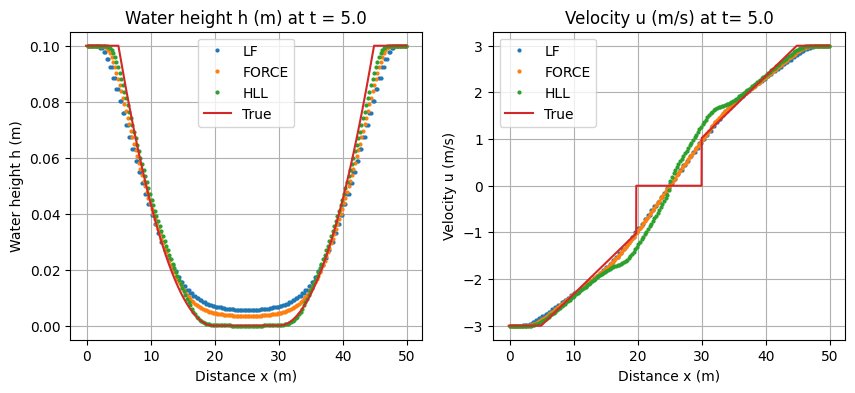

In [10]:
# Physical parameters
xL = 0
xR = 50
t = 0
tend = 5.0

# Numerical parameters
Nx = 1000 # the number of the cell-centers
dx = (xR - xL) / Nx  # distance between the mesh points
x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)

# Initial conditions
h = np.zeros(Nx)
u = np.zeros(Nx)
hL = 0.1
hR = 0.1
uL = -3.0
uR = 3.0
x0 = 25.0

# Define initial water height and velocity
h = np.where(x < x0, hL, hR)           
u = np.where(x < x0, uL, uR)

# Plot the initial data
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(x, h)
plt.grid()
plt.ylabel('Water height h (m)')
plt.xlabel('Distance x (m)')
plt.title('Initial water height h (m)')

plt.subplot(1, 2, 2)
plt.plot(x, u)
plt.grid()
plt.ylabel('Velocity u (m/s)')
plt.xlabel('Distance x (m)')
plt.title('Initial velocity u (m/s)')

# Save figure
if save:
    plt.savefig('plots/toro_test5_initial.pdf', format='pdf')

plt.show()

# Import numerical and true solution from Matlab - Godunov method and split upwind does not work
mat_data = loadmat('data/torotest5flux2.mat')
xc = mat_data['xc']
h_LF = mat_data['h']
u_LF = mat_data['u']
xexact = mat_data['xexact']
hexact = mat_data['hexact']
uexact = mat_data['uexact']

# Load other numerical solutions
mat_data = loadmat('data/torotest5flux3.mat')
h_LW = mat_data['h']
u_LW = mat_data['u']

mat_data = loadmat('data/torotest5flux4.mat')
h_FORCE = mat_data['h']
u_FORCE = mat_data['u']

mat_data = loadmat('data/torotest5flux5.mat')
h_HLL = mat_data['h']
u_HLL = mat_data['u']

# Plot the final data
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(xc[0,:], h_LF[0,:], 'o', markersize = 2, label='LF')
#plt.plot(xc[0,:], h_LW[0,:], 'o', markersize = 2, label='LW')
plt.plot(xc[0,:], h_FORCE[0,:], 'o', markersize = 2, label='FORCE')
plt.plot(xc[0,:], h_HLL[0,:], 'o', markersize = 2, label='HLL')
plt.plot(xexact[0, :], hexact[0, :], label='True')
plt.legend()
plt.grid()
plt.ylabel('Water height h (m)')
plt.xlabel('Distance x (m)')
plt.title(f'Water height h (m) at t = {tend}')

plt.subplot(1, 2, 2)
plt.plot(xc[0,:], u_LF[0,:], 'o', markersize = 2, label='LF')
#plt.plot(xc[0,:], u_LW[0,:], 'o', markersize = 2, label='LW')
plt.plot(xc[0,:], u_FORCE[0,:], 'o', markersize = 2, label='FORCE')
plt.plot(xc[0,:], u_HLL[0,:], 'o', markersize = 2, label='HLL')
plt.plot(xexact[0, :], uexact[0, :], label='True')
plt.legend()
plt.grid()
plt.ylabel('Velocity u (m/s)')
plt.xlabel('Distance x (m)')
plt.title(f'Velocity u (m/s) at t= {tend}')

# Save figure
if save:
    plt.savefig('plots/toro_test5_final.pdf', format='pdf')

plt.show()

# 2D Dam break problem

### Functions
The MUSCL-Hancock scheme for the 2D SWE with the Rusanov numerical flux.

In [3]:
# Define the global gravity constant
g = 9.81

def FluxX(Q):
    # Initialize F to the same shape as Q
    F = np.zeros_like(Q)

    # Compute the flux in the x-direction    
    F[0, :, :] = Q[1, :, :]
    F[1, :, :] = Q[1, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2
    F[2, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]

    return F


def FluxY(Q):
    # Initialize G to the same shape as Q
    G = np.zeros_like(Q)

    # Compute the flux in the y-direction
    G[0, :, :] = Q[2, :, :]
    G[1, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]
    G[2, :, :] = Q[2, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2

    return G

def Lambdax(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity and wave speed
    u = Q[1, :, :] / Q[0, :, :]  # u = hu / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the x-direction
    L[0, :, :] = u - c
    L[1, :, :] = u
    L[2, :, :] = u + c

    return L

def Lambday(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity in y-direction and wave speed
    v = Q[2, :, :] / Q[0, :, :]  # v = hv / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the y-direction
    L[0, :, :] = v - c
    L[1, :, :] = v
    L[2, :, :] = v + c

    return L

def minmodarray(a, b):
    nVar, Nx, Ny = a.shape
    c = np.zeros((nVar, Nx, Ny))

    for i in range(nVar):
        # First condition: a * b > 0 and |a| < |b|
        logic1 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) < np.abs(b[i, :, :]))
        c[i, :, :] = a[i, :, :] * logic1
        
        # Second condition: a * b > 0 and |a| > |b|
        logic2 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) > np.abs(b[i, :, :]))
        c[i, :, :] += b[i, :, :] * logic2

    return c

def Rusanov(QL, QR, FL, FR, sL, sR):
    smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    F = 0.5 * (FR + FL) - 0.5 * smax * (QR - QL)
    return F

def Rusanov(QL, QR, FL, FR, sL, sR):
    smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    QL = QL.reshape(3,)
    QR = QR.reshape(3,)
    FL = FL.reshape(3,)
    FR = FR.reshape(3,)
    sL = sL.reshape(3,)
    sR = sR.reshape(3,)
    F = 0.5 * (FR + FL) - 0.5 * smax * (QR - QL)
    return F


### Asymmetric Dam Break

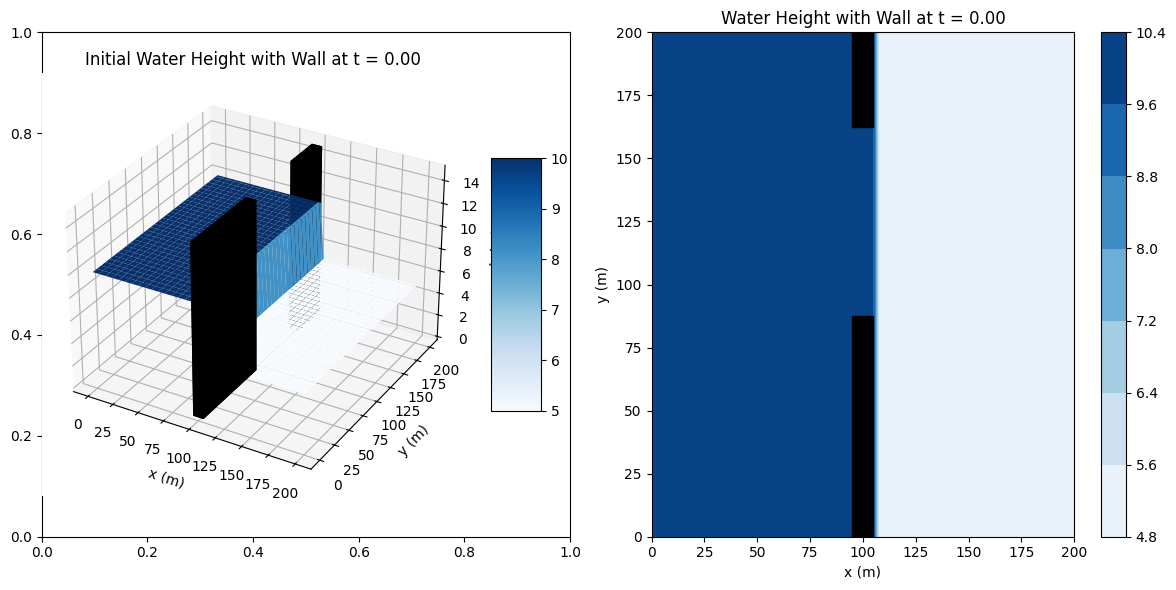

In [12]:
# Global constants
g = 9.81
Nx = 64
Ny = 64
Lx = 200
Ly = 200

t = 0
CFL = 0.9

# Define the grid
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
dx = x[1] - x[0]
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y)

# Define the initial conditions
Q = np.zeros((3, Nx, Ny))
Qnew = np.copy(Q)


hL = 10.0
hR = 5.0

# Initialize the water height with a wall from x = 95 to 105
for i in range(Nx):
    if x[i] > 105:
        Q[0, :, i] = hR
    else:
        Q[0, :, i] = hL

# Define the position and dimensions of the wall
x_wall = 95
y_wall = 0
width = 105 - 95  
depth = 87.5
height = 15 

y_wall2 = 162.5
depth2 = 200 - 162.5

# Plot the initial data in 3D and as a contour plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
cmap = 'Blues'

# 3D Surface plot on the first subplot
ax1 = fig.add_subplot(121, projection='3d')
surface = ax1.plot_surface(X, Y, Q[0, :, :], cmap=cmap)
ax1.set_title(f'Initial Water Height with Wall at t = {t:.2f}')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_zlabel('h (m)')
fig.colorbar(surface, ax=ax1, shrink=0.5, aspect=5)     

# Plot the solid walls using bar3d
ax1.bar3d(x_wall, y_wall, 0, width, depth, height, color='black', alpha=1)
ax1.bar3d(x_wall, y_wall2, 0, width, depth2, height, color='black', alpha=1)


# Contour plot on the second subplot
ax2 = axes[1]
contour = ax2.contourf(X, Y, Q[0, :, :], cmap=cmap)
fig.colorbar(contour, ax=ax2)
ax2.set_title(f'Water Height with Wall at t = {t:.2f}')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')

# Add the wall as a shaded area in the contour plot
ax2.fill_betweenx(np.linspace(0, depth, 20), x_wall, 105, color='black', alpha=1)
ax2.fill_betweenx(np.linspace(162.5, 200, 20), x_wall, 105, color='black', alpha=1)

# Show the combined plot
plt.tight_layout()
plt.show()


In [13]:
# Global constants
g = 9.81
Nx = 64
Ny = 64
Lx = 200
Ly = 200

t = 0
tend = 5

CFL = 0.9

# Define the grid
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
dx = x[1] - x[0]
dy = y[1] - y[0]
X, Y = np.meshgrid(x, y)

# Define the initial conditions
Q = np.zeros((3, Nx, Ny))
Qnew = np.copy(Q)

hL = 10.0
hR = 5.0

# Initialize the water height with a wall from x = 95 to 105
for i in range(Nx):
    if x[i] > 105:
        Q[0, :, i] = hR
    else:
        Q[0, :, i] = hL


Q_all = []
Q_all.append(Q)

x_min = 95
x_max = 105
y_min = 0
y_max = 87.5

y_min_2 = 162.5
y_max_2 = 200 

# Start timer
start_time = time.time()

# Time loop
for n in range(100000):
    sx = Lambdax(Q)  # characteristic velocities in x-direction
    sy = Lambday(Q)  # characteristic velocities in y-direction
    ax = np.max(np.abs(sx))
    ay = np.max(np.abs(sy))
    
    dt = CFL / (ax / dx + ay / dy)
    if t + dt > tend:
        dt = tend - t
    if t >= tend:
        break

    # MUSCL part
    slopeX = np.zeros_like(Q)
    slopeY = np.zeros_like(Q)
    
    slopeX[:, 1:Nx-1, :] = minmodarray(Q[:, 1:Nx-1, :] - Q[:, 0:Nx-2, :], Q[:, 2:Nx, :] - Q[:, 1:Nx-1, :])
    slopeY[:, :, 1:Ny-1] = minmodarray(Q[:, :, 1:Ny-1] - Q[:, :, 0:Ny-2], Q[:, :, 2:Ny] - Q[:, :, 1:Ny-1])

    Qxm = Q - 0.5 * slopeX
    Qxp = Q + 0.5 * slopeX
    Qym = Q - 0.5 * slopeY
    Qyp = Q + 0.5 * slopeY

    Q_t = -(FluxX(Qxp) - FluxX(Qxm)) / dx - (FluxY(Qyp) - FluxY(Qym)) / dy
    Qxm += 0.5 * dt * Q_t
    Qxp += 0.5 * dt * Q_t
    Qym += 0.5 * dt * Q_t
    Qyp += 0.5 * dt * Q_t

    # Recompute physical fluxes and characteristic velocities for Rusanov flux
    fxm, fxp = FluxX(Qxm), FluxX(Qxp)
    gym, gyp = FluxY(Qym), FluxY(Qyp)
    
    sxm, sxp = Lambdax(Qxm), Lambdax(Qxp)
    sym, syp = Lambday(Qym), Lambday(Qyp)

    dtdx = dt / dx
    dtdy = dt / dy

    # Space loop
    for i in range(Nx):
        for j in range(Ny):
            # Reflective boundary condition (no crossing, reflecting like a wall)
            if x_min <= x[j] <= x_max and y_min <= y[i] <= y_max:
                # Reflect at boundaries
                Fm = np.zeros(3)
                Fp = np.zeros(3)
                Gm = np.zeros(3)
                Gp = np.zeros(3)
  
            elif x_min <= x[j] <= x_max and y_min_2 <= y[i] <= y_max_2:
                # Apply no-flux boundary condition at the solid wall (set fluxes to zero)
                Fm = np.zeros(3)
                Fp = np.zeros(3)
                Gm = np.zeros(3)
                Gp = np.zeros(3)

            else:
                # Numerical fluxes in X
                if i == 0:
                    Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                    Qghost[1] = -Qghost[1]
                    Fm = Rusanov(Qghost, Qxm[:, i, j], FluxX(Qghost), fxm[:, i, j], Lambdax(Qghost), sxm[:, i, j])
                    Fp = Rusanov(Qxp[:, i, j], Qxm[:, i+1, j], fxp[:, i, j], fxm[:, i+1, j], sxp[:, i, j], sxm[:, i+1, j])
                elif i == Nx - 1:
                    Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                    Qghost[1] = -Qghost[1]
                    Fm = Rusanov(Qxp[:, i-1, j], Qxm[:, i, j], fxp[:, i-1, j], fxm[:, i, j], sxp[:, i-1, j], sxm[:, i, j])
                    Fp = Rusanov(Qxp[:, i, j], Qghost, fxp[:, i, j], FluxX(Qghost), sxp[:, i, j], Lambdax(Qghost))
                else:
                    Fm = Rusanov(Qxp[:, i-1, j], Qxm[:, i, j], fxp[:, i-1, j], fxm[:, i, j], sxp[:, i-1, j], sxm[:, i, j])
                    Fp = Rusanov(Qxp[:, i, j], Qxm[:, i+1, j], fxp[:, i, j], fxm[:, i+1, j], sxp[:, i, j], sxm[:, i+1, j])

                # Numerical fluxes in Y
                if j == 0:
                    Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                    Qghost[2] = -Qghost[2]
                    Gm = Rusanov(Qghost, Qym[:, i, j], FluxY(Qghost), gym[:, i, j], Lambday(Qghost), sym[:, i, j])
                    Gp = Rusanov(Qyp[:, i, j], Qym[:, i, j+1], gyp[:, i, j], gym[:, i, j+1], syp[:, i, j], sym[:, i, j+1])
                elif j == Ny - 1:
                    Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                    Qghost[2] = -Qghost[2]
                    Gm = Rusanov(Qyp[:, i, j-1], Qym[:, i, j], gyp[:, i, j-1], gym[:, i, j], syp[:, i, j-1], sym[:, i, j])
                    Gp = Rusanov(Qyp[:, i, j], Qghost, gyp[:, i, j], FluxY(Qghost), syp[:, i, j], Lambday(Qghost))
                else:
                    Gm = Rusanov(Qyp[:, i, j-1], Qym[:, i, j], gyp[:, i, j-1], gym[:, i, j], syp[:, i, j-1], sym[:, i, j])
                    Gp = Rusanov(Qyp[:, i, j], Qym[:, i, j+1], gyp[:, i, j], gym[:, i, j+1], syp[:, i, j], sym[:, i, j+1])

            # Finite volume update
            Qnew[:, i, j] = Q[:, i, j] - dtdx * (Fp - Fm) - dtdy * (Gp - Gm)
            
    # Update time and solution
    t += dt
    # Print t with 3 decimals
    print(f't = {t:.3f}')
    Q = np.copy(Qnew)
    Q_all.append(Q)

n = len(Q_all)
print(f'There are time steps: {n}')

# End timer
end_time = time.time()

# Print the time taken
elapsed_time = end_time - start_time
print(f'Time taken: {elapsed_time:.2f} seconds')


t = 0.144
t = 0.286
t = 0.425
t = 0.562
t = 0.698
t = 0.832
t = 0.965
t = 1.097
t = 1.228
t = 1.359
t = 1.489
t = 1.619
t = 1.748
t = 1.877
t = 2.006
t = 2.134
t = 2.262
t = 2.390
t = 2.518
t = 2.645
t = 2.772
t = 2.899
t = 3.026
t = 3.152
t = 3.279
t = 3.405
t = 3.531
t = 3.657
t = 3.783
t = 3.908
t = 4.033
t = 4.158
t = 4.283
t = 4.407
t = 4.531
t = 4.655
t = 4.779
t = 4.902
t = 5.000
There are time steps: 40
Time taken: 13.05 seconds


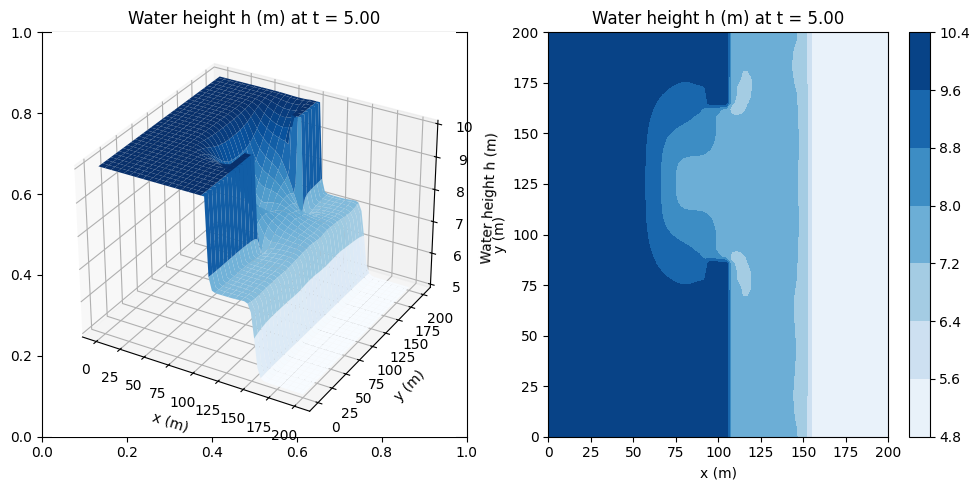

In [14]:
save = 0

# Plot the final data in 3D and in contour
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 3D Surface plot on the first subplot
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, Q[0, :, :], cmap=cmap)
ax1.set_title(f'Water height h (m) at t = {t:.2f}')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_zlabel('Water height h (m)')

# Contour plot on the second subplot
ax2 = axes[1]
contour = ax2.contourf(X, Y, Q[0, :, :], cmap=cmap)
fig.colorbar(contour, ax=ax2)
ax2.set_title(f'Water height h (m) at t = {t:.2f}')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')

plt.tight_layout()

# Save figure
if save:
    filename = f'plots/toro2D_t={tend}.pdf'
    plt.savefig(filename, format='pdf')

plt.show()

Animation saved


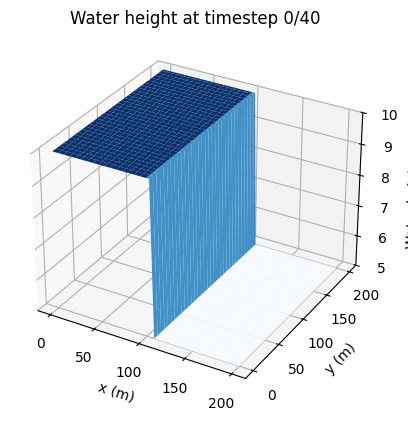

In [15]:
# Make animation
if 1:
    # Assuming Nx and Ny are the dimensions of your data
    Nx, Ny = Q_all[0][0].shape
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y)

    # Set up the figure and 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlim(np.min(Q_all[0][0]), np.max(Q_all[0][0]))
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('Water height h (m)')

    # Initial surface plot
    surf = ax.plot_surface(X, Y, Q_all[0][0], cmap=cmap)

    # Update function for the animation
    def update(frame):
        ax.clear()
        ax.set_zlim(np.min(Q_all[0][0]), np.max(Q_all[0][0]))
        ax.set_xlabel('x (m)')
        ax.set_ylabel('y (m)')
        ax.set_zlabel('Water height h (m)')
        ax.set_title(f'Water height at timestep {frame}/{n}')
        surf = ax.plot_surface(X, Y, Q_all[frame][0], cmap=cmap)
        return [surf]

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=len(Q_all), interval=100)

    # Save animation
    ani.save('animations/Asymmetric_dam_break_prob_2D_11112024.html', writer='html')
    dpi = 200
    ani.save('animations/Asymmetric_dam_break_prob_2D_11112024.gif', writer='pillow', dpi=dpi)

    print('Animation saved')


### Idealised 2D dam break

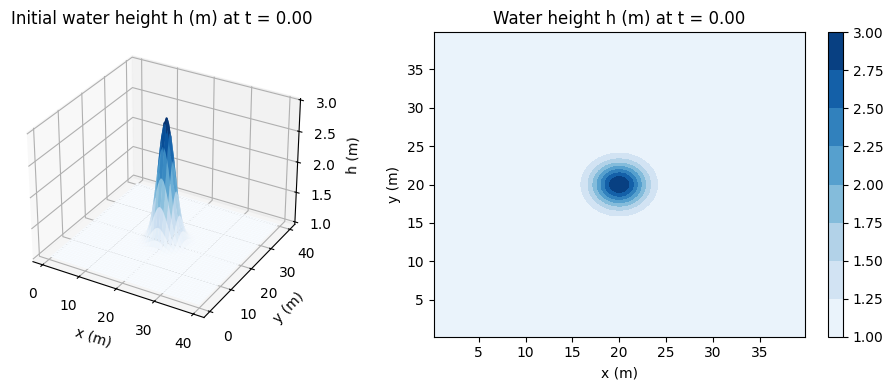

In [7]:
# Global constants
g = 9.81  # gravity
Nx = 100
Ny = Nx
xL, xR = 0, 40
yL, yR = 0, 40
t = 0
tend = 5
CFL = 0.9

dx = (xR - xL) / Nx
dy = (yR - yL) / Ny

x = np.linspace(xL + dx / 2, xR - dx / 2, Nx)
y = np.linspace(yL + dy / 2, yR - dy / 2, Ny)

# Center
xc = 20
yc = 20

# Radius
R = 2.5

# Initial conditions for the water height
Q = np.zeros((3, Nx, Ny))
Qnew = np.copy(Q)

# Define initial condition
ic = 2

if ic == 1:
    for i in range(Nx):
        for j in range(Ny):
            r = np.sqrt((x[i] - xc)**2 + (y[j] - yc)**2)
            if r < R:
                Q[0, i, j] = 2.5
            else:
                Q[0, i, j] = 0.5

# Initial condition Gauss function
sigma = 2
if ic == 2:
    for i in range(Nx):
        for j in range(Ny):
            Q[0, i, j] = 1.0 + 2 * np.exp(-((x[i] - xc)**2 + (y[j] - yc)**2) / (2 * sigma**2))

cmap = 'Blues'
# Plot the initial data in 3d and in contour
fig = plt.figure(figsize=(10, 4))


# 3D Surface plot on the first subplot
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, Q[0, :, :], cmap=cmap)
ax1.set_title(f'Initial water height h (m) at t = {t:.2f}')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_zlabel('h (m)')

# Contour plot on the second subplot
ax2 = fig.add_subplot(122)
contour = ax2.contourf(X, Y, Q[0, :, :], cmap=cmap)
fig.colorbar(contour, ax=ax2)
ax2.set_title(f'Water height h (m) at t = {t:.2f}')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')

# Show the combined plot
plt.tight_layout()
plt.show()

In [8]:
Q_all = []
Q_all.append(Q)
t_all = []
t_all.append(t)

# Start timer
start_time = time.time()

# Time loop
for n in range(100000):
    sx = Lambdax(Q)  # characteristic velocities in x-direction
    sy = Lambday(Q)  # characteristic velocities in y-direction
    ax = np.max(np.abs(sx))
    ay = np.max(np.abs(sy))
    
    dt = CFL / (ax / dx + ay / dy)
    if t + dt > tend:
        dt = tend - t
    if t >= tend:
        break

    # MUSCL part
    slopeX = np.zeros_like(Q)
    slopeY = np.zeros_like(Q)
    
    slopeX[:, 1:Nx-1, :] = minmodarray(Q[:, 1:Nx-1, :] - Q[:, 0:Nx-2, :], Q[:, 2:Nx, :] - Q[:, 1:Nx-1, :])
    slopeY[:, :, 1:Ny-1] = minmodarray(Q[:, :, 1:Ny-1] - Q[:, :, 0:Ny-2], Q[:, :, 2:Ny] - Q[:, :, 1:Ny-1])

    Qxm = Q - 0.5 * slopeX
    Qxp = Q + 0.5 * slopeX
    Qym = Q - 0.5 * slopeY
    Qyp = Q + 0.5 * slopeY

    Q_t = -(FluxX(Qxp) - FluxX(Qxm)) / dx - (FluxY(Qyp) - FluxY(Qym)) / dy
    Qxm += 0.5 * dt * Q_t
    Qxp += 0.5 * dt * Q_t
    Qym += 0.5 * dt * Q_t
    Qyp += 0.5 * dt * Q_t

    # Recompute physical fluxes and characteristic velocities for Rusanov flux
    fxm, fxp = FluxX(Qxm), FluxX(Qxp)
    gym, gyp = FluxY(Qym), FluxY(Qyp)
    
    sxm, sxp = Lambdax(Qxm), Lambdax(Qxp)
    sym, syp = Lambday(Qym), Lambday(Qyp)

    dtdx = dt / dx
    dtdy = dt / dy

    # Space loop
    for i in range(Nx):
        for j in range(Ny):
            # Numerical fluxes in X
            if i == 0:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                Qghost[1] = -Qghost[1]
                Fm = Rusanov(Qghost, Qxm[:, i, j], FluxX(Qghost), fxm[:, i, j], Lambdax(Qghost), sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qxm[:, i+1, j], fxp[:, i, j], fxm[:, i+1, j], sxp[:, i, j], sxm[:, i+1, j])
            elif i == Nx - 1:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                Qghost[1] = -Qghost[1]
                Fm = Rusanov(Qxp[:, i-1, j], Qxm[:, i, j], fxp[:, i-1, j], fxm[:, i, j], sxp[:, i-1, j], sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qghost, fxp[:, i, j], FluxX(Qghost), sxp[:, i, j], Lambdax(Qghost))
            else:
                Fm = Rusanov(Qxp[:, i-1, j], Qxm[:, i, j], fxp[:, i-1, j], fxm[:, i, j], sxp[:, i-1, j], sxm[:, i, j])
                Fp = Rusanov(Qxp[:, i, j], Qxm[:, i+1, j], fxp[:, i, j], fxm[:, i+1, j], sxp[:, i, j], sxm[:, i+1, j])

            # Numerical fluxes in Y
            if j == 0:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                Qghost[2] = -Qghost[2]
                Gm = Rusanov(Qghost, Qym[:, i, j], FluxY(Qghost), gym[:, i, j], Lambday(Qghost), sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qym[:, i, j+1], gyp[:, i, j], gym[:, i, j+1], syp[:, i, j], sym[:, i, j+1])
            elif j == Ny - 1:
                Qghost = Q[:, i, j].reshape(3, 1, 1).copy()  # Reshape to (3, 1, 1)
                Qghost[2] = -Qghost[2]
                Gm = Rusanov(Qyp[:, i, j-1], Qym[:, i, j], gyp[:, i, j-1], gym[:, i, j], syp[:, i, j-1], sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qghost, gyp[:, i, j], FluxY(Qghost), syp[:, i, j], Lambday(Qghost))
            else:
                Gm = Rusanov(Qyp[:, i, j-1], Qym[:, i, j], gyp[:, i, j-1], gym[:, i, j], syp[:, i, j-1], sym[:, i, j])
                Gp = Rusanov(Qyp[:, i, j], Qym[:, i, j+1], gyp[:, i, j], gym[:, i, j+1], syp[:, i, j], sym[:, i, j+1])

            # Finite volume update
            Qnew[:, i, j] = Q[:, i, j] - dtdx * (Fp - Fm) - dtdy * (Gp - Gm)
            

    # Update time and solution
    t += dt
    # Print t with 3 decimals
    print(f't = {t:.3f}')
    t_all.append(t)
    Q = np.copy(Qnew)
    Q_all.append(Q)

n = len(Q_all)
print(f'There are time steps: {n}')

# End timer
end_time = time.time()

# Print the time taken
elapsed_time = end_time - start_time
print(f'Time taken: {elapsed_time:.2f} seconds')


t = 0.033
t = 0.067
t = 0.100
t = 0.132
t = 0.165
t = 0.197
t = 0.229
t = 0.261
t = 0.293
t = 0.324
t = 0.356
t = 0.388
t = 0.420
t = 0.451
t = 0.483
t = 0.515
t = 0.548
t = 0.580
t = 0.613
t = 0.646
t = 0.679
t = 0.712
t = 0.745
t = 0.779
t = 0.813
t = 0.847
t = 0.882
t = 0.917
t = 0.951
t = 0.987
t = 1.022
t = 1.057
t = 1.093
t = 1.129
t = 1.165
t = 1.201
t = 1.238
t = 1.274
t = 1.311
t = 1.348
t = 1.385
t = 1.422
t = 1.460
t = 1.497
t = 1.535
t = 1.573
t = 1.611
t = 1.649
t = 1.687
t = 1.726
t = 1.764
t = 1.803
t = 1.842
t = 1.881
t = 1.920
t = 1.959
t = 1.998
t = 2.038
t = 2.077
t = 2.117
t = 2.157
t = 2.197
t = 2.237
t = 2.277
t = 2.317
t = 2.358
t = 2.398
t = 2.439
t = 2.480
t = 2.521
t = 2.562
t = 2.603
t = 2.644
t = 2.685
t = 2.726
t = 2.768
t = 2.809
t = 2.851
t = 2.893
t = 2.935
t = 2.977
t = 3.019
t = 3.061
t = 3.103
t = 3.145
t = 3.188
t = 3.230
t = 3.273
t = 3.316
t = 3.358
t = 3.401
t = 3.444
t = 3.487
t = 3.530
t = 3.573
t = 3.617
t = 3.660
t = 3.703
t = 3.747
t = 3.790


In [16]:
# Save as .h5 file
if 0:
    filename = f'dataFNO/toro2D_N={Nx}_t={tend}.h5'
    with h5py.File(filename, 'w') as file:
        file.create_dataset('Q_all', data=Q_all)
        file.create_dataset('t_all', data=t_all)
        file.create_dataset('x', data=x)
        file.create_dataset('y', data=y)
    print(f'Data saved to {filename}')


Data saved to dataFNO/toro2D_N=100_t=5.h5


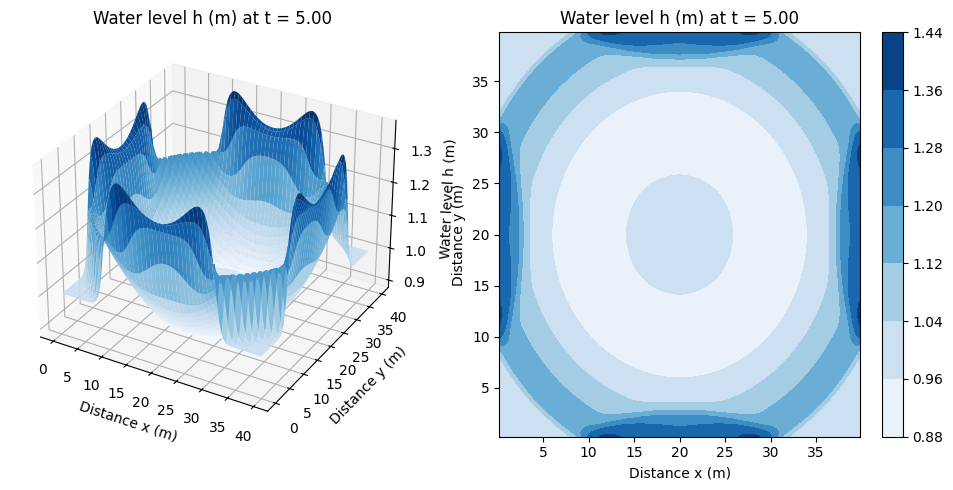

In [10]:
save = 0

# Prepare grid
X, Y = np.meshgrid(x, y)

from matplotlib import gridspec

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 2])  # Adjust width ratios: [2, 1] makes the first plot twice as wide as the second

# First plot (3D)
ax1 = fig.add_subplot(gs[0], projection='3d')
surf = ax1.plot_surface(X, Y, Q[0, :, :], cmap=cmap)
ax1.set_title(f'Water level h (m) at t = {t:.2f}')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Distance y (m)')
ax1.set_zlabel('Water level h (m)')
# fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)

# Second plot (Contour)
ax2 = fig.add_subplot(gs[1])
contour = ax2.contourf(X, Y, Q[0, :, :], cmap=cmap)
fig.colorbar(contour, ax=ax2)
ax2.set_title(f'Water level h (m) at t = {t:.2f}')
ax2.set_xlabel('Distance x (m)')
ax2.set_ylabel('Distance y (m)')

plt.tight_layout()

# Save figure
if save:
    filename = f'plots/toro2D_t={tend}.pdf'
    plt.savefig(filename, format='pdf')

plt.show()

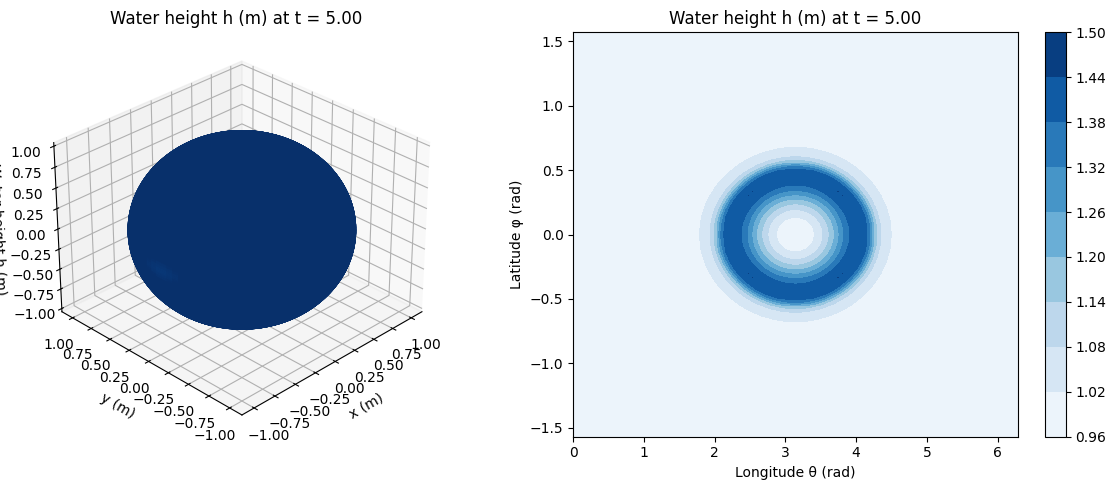

In [11]:
## Wrap on a sphere
idx = 28

# Define grid in lat/lon space (latitude φ, longitude θ)
phi = np.linspace(-np.pi/2, np.pi/2, Q.shape[1])  # Latitude range from -90° to 90°
theta = np.linspace(0, 2*np.pi, Q.shape[2])  # Longitude range from 0° to 360°
cmap = 'Blues'

# Convert to meshgrid for spherical coordinates
phi, theta = np.meshgrid(phi, theta)

# Convert to Cartesian coordinates for plotting on the sphere
r = 1  # Radius of the sphere (can be adjusted)
X_sphere = r * np.cos(phi) * np.cos(theta)  # X coordinate
Y_sphere = r * np.cos(phi) * np.sin(theta)  # Y coordinate
Z_sphere = r * np.sin(phi)  # Z coordinate

# Plot the final data in 3D and in contour
fig = plt.figure(figsize=(12, 5))

# 3D Surface plot on the first subplot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X_sphere, Y_sphere, Z_sphere, facecolors=plt.cm.Blues(Q_all[idx][0, :, :]), rstride=1, cstride=1, antialiased=True, shade=False)
ax1.set_title(f'Water height h (m) at t = {t:.2f}')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.view_init(30, 45+180)
ax1.set_zlabel('Water height h (m)')

# Contour plot on the second subplot
ax2 = fig.add_subplot(122)
contour = ax2.contourf(theta, phi, Q_all[idx][0, :, :], cmap=cmap)
fig.colorbar(contour, ax=ax2)
ax2.set_title(f'Water height h (m) at t = {t:.2f}')
ax2.set_xlabel('Longitude θ (rad)')
ax2.set_ylabel('Latitude φ (rad)')

plt.tight_layout()
plt.show()



In [12]:
# Make animation
if 0:
    # Assuming Nx and Ny are the dimensions of your data
    Nx, Ny = Q_all[0][0].shape
    x = np.linspace(0, Nx-1, Nx)
    y = np.linspace(0, Ny-1, Ny)
    X, Y = np.meshgrid(x, y)

    # Set up the figure and 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlim(np.min(Q_all[0][0]), np.max(Q_all[0][0]))
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_zlabel('Water height h (m)')

    # Initial surface plot
    surf = ax.plot_surface(X, Y, Q_all[0][0], cmap=cmap)

    # Update function for the animation
    def update(frame):
        ax.clear()
        ax.set_zlim(np.min(Q_all[0][0]), np.max(Q_all[0][0]))
        ax.set_xlabel('x (m)')
        ax.set_ylabel('y (m)')
        ax.set_zlabel('Water height h (m)')
        ax.set_title(f'Water height at timestep {frame}/{n}')
        surf = ax.plot_surface(X, Y, Q_all[frame][0], cmap=cmap)
        return [surf]

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=len(Q_all), interval=100)

    # Display the animation
    plt.show()


In [13]:
# Save animation
#ani.save('animations/toro2D_FVM_08112024_N128.html', writer='html')
#dpi = 200
#ani.save('animations/toro2D_FVM_08112024_N128.gif', writer='pillow', dpi=dpi)

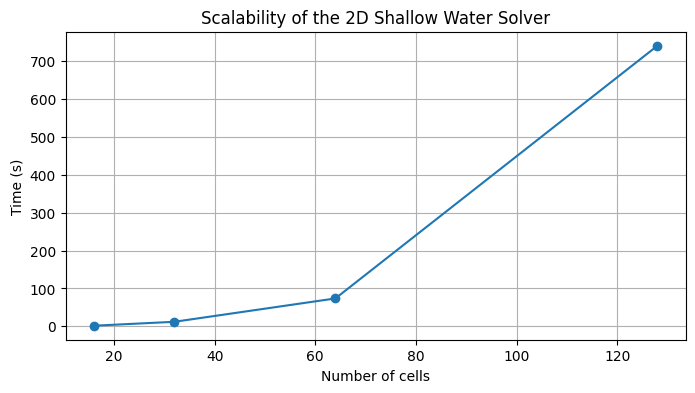

In [14]:
# Scalability issues
times = [(16,1.63), (32, 11.99), (64, 73.63), (128, 740.76)]

# Plot the scalability
plt.figure(figsize=(8, 4))
plt.plot(*zip(*times), marker='o')
plt.grid()
plt.xlabel('Number of cells')
plt.ylabel('Time (s)')
plt.title('Scalability of the 2D Shallow Water Solver')

plt.show()
